# **MovieLens 32M Recommendation System Project**

## Overview
This notebook focuses on the initial stages of building a recommendation system using the MovieLens 32M dataset. Specifically, I will perform data cleaning and preprocessing, followed by exploratory data analysis (EDA). These steps are crucial to understanding the data and preparing it for feature engineering and model development in subsequent stages.

## Objectives
- **Data Cleaning and Preprocessing**: 
  - Convert timestamps from Unix epoch to a human-readable datetime format.
  - Identify and handle any missing values.
  - Ensure all columns have the correct data types.

- **Exploratory Data Analysis (EDA)**: 
  - Compute basic statistics for each dataset.
  - Analyse the distribution of ratings and tags.
  - Explore user behaviour patterns.
  - Visualise data distributions to gain insights.

## Steps

### Step 1: Data Cleaning and Preprocessing
- Convert Unix epoch timestamps to human-readable datetime format.
- Identify and handle missing values.
- Ensure all columns have the correct data types.

### Step 2: Exploratory Data Analysis (EDA)
- Compute basic statistics for each dataset.
- Analyse the distribution of ratings, number of tags per movie, and user behaviour patterns.
- Visualise data distributions to gain insights.

## Project Status
- [x] Data Cleaning and Preprocessing
- [x] Exploratory Data Analysis (EDA)
- [ ] Feature Engineering
- [ ] Model Development
- [ ] Model Evaluation
- [ ] Model Deployment

---

By focusing on these initial steps, I aim to clean and understand the MovieLens 32M dataset, setting a solid foundation for further feature engineering and model development.


## Data Loading
I will load the following datasets from the MovieLens 32M dataset:
- `tags.csv`: Contains user-generated tags for movies.
- `ratings.csv`: Contains user ratings for movies, including timestamps.
- `movies.csv`: Contains movie metadata such as titles and genres.
- `links.csv`: Contains identifiers that link MovieLens IDs with IMDb and TMDb IDs.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

# File paths
tags_path = "../data/raw/tags.csv"
ratings_path = "../data/raw/ratings.csv"
movies_path = "../data/raw/movies.csv"
links_path = "../data/raw/links.csv"

# Read CSV files into DataFrames
tags_df = pd.read_csv(tags_path)
tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp'], unit='s')
ratings_df = pd.read_csv(ratings_path)
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
movies_df = pd.read_csv(movies_path)
links_df = pd.read_csv(links_path)

# Ensure correct data types
tags_df['movieId'] = tags_df['movieId'].astype(int)
ratings_df['movieId'] = ratings_df['movieId'].astype(int)
movies_df['movieId'] = movies_df['movieId'].astype(int)
links_df['movieId'] = links_df['movieId'].astype(int)



## Data Overview
Let's inspect the first few rows of each DataFrame to understand their structure and content.


### Tags DataFrame
The `tags` DataFrame contains user-generated tags for movies. It includes the following columns:
- `userId`: The ID of the user who tagged the movie.
- `movieId`: The ID of the movie that was tagged.
- `tag`: The tag applied by the user.
- `timestamp`: The time the tag was applied.


In [2]:
# Display the first few rows of the tags DataFrame
print("Tags DataFrame:")
tags_df.head()


Tags DataFrame:


,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,2020-03-01 05:01:26
1,22,79592,misogyny,2020-02-12 02:58:17
2,22,247150,acrophobia,2021-05-31 17:51:09
3,34,2174,music,2009-08-09 08:54:24
4,34,2174,weird,2009-08-09 08:55:02


### Ratings DataFrame
The `ratings` DataFrame contains user ratings for movies. It includes the following columns:
- `userId`: The ID of the user who rated the movie.
- `movieId`: The ID of the movie that was rated.
- `rating`: The rating given by the user.
- `timestamp`: The time the rating was given.


In [3]:
# Display the first few rows of the ratings DataFrame
print("\nRatings DataFrame:")
ratings_df.head()


Ratings DataFrame:


,userId,movieId,rating,timestamp
0,1,17,4.0,1999-12-03 19:24:37
1,1,25,1.0,1999-12-03 19:43:48
2,1,29,2.0,1999-11-22 00:36:16
3,1,30,5.0,1999-12-03 19:24:37
4,1,32,5.0,1999-11-22 00:00:58


### Movies DataFrame
The `movies` DataFrame contains metadata for movies. It includes the following columns:
- `movieId`: The ID of the movie.
- `title`: The title of the movie.
- `genres`: The genres of the movie.


In [4]:
# Display the first few rows of the movies DataFrame
print("\nMovies DataFrame:")
movies_df.head()


Movies DataFrame:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Links DataFrame
The `links` DataFrame contains identifiers that link MovieLens IDs with IMDb and TMDb IDs. It includes the following columns:
- `movieId`: The ID of the movie.
- `imdbId`: The IMDb ID of the movie.
- `tmdbId`: The TMDb ID of the movie.


In [5]:
# Display the first few rows of the links DataFrame
print("\nLinks DataFrame:")
links_df.head()


Links DataFrame:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## **Checking for Unique `movieId`**

Before I proceed with joining the datasets, it's crucial to ensure that the `movieId` column is unique where it should be. Specifically, we need to confirm that `movieId` is unique in the `movies_df` and `links_df`, which serve as reference tables. For `ratings_df` and `tags_df`, having duplicate `movieId` values is expected since multiple users can rate and tag the same movie multiple times.

I will:
1. Check the uniqueness of `movieId` in each DataFrame.
2. Identify and count duplicate `movieId` entries in each DataFrame.

### Steps

1. **Check Uniqueness**: Verify that `movieId` is unique in `movies_df` and `links_df`.
2. **Identify Duplicates**: Count and display duplicate `movieId` entries in `ratings_df` and `tags_df`.

The results will guide our strategy for joining the datasets without introducing false duplicates.

### Expected Results

- `movies_df` and `links_df` should have unique `movieId`.
- `ratings_df` and `tags_df` are expected to have duplicate `movieId` entries due to multiple user interactions per movie.



In [6]:
# Check if movieId is unique in each DataFrame
def check_unique_movie_id(df, df_name):
    is_unique = df['movieId'].is_unique
    if is_unique:
        print(f"'{df_name}': 'movieId' is unique.")
    else:
        print(f"'{df_name}': 'movieId' is NOT unique.")

# Check uniqueness in each DataFrame
check_unique_movie_id(movies_df, 'movies_df')
check_unique_movie_id(ratings_df, 'ratings_df')
check_unique_movie_id(tags_df, 'tags_df')
check_unique_movie_id(links_df, 'links_df')

# Check for duplicates directly
print("\nChecking for duplicate movieIds in each DataFrame:")

# For movies_df
duplicate_movie_ids_movies = movies_df[movies_df.duplicated('movieId')]
print(f"movies_df: {duplicate_movie_ids_movies.shape[0]} duplicate movieId(s) found.")

# For ratings_df
duplicate_movie_ids_ratings = ratings_df[ratings_df.duplicated('movieId')]
print(f"ratings_df: {duplicate_movie_ids_ratings.shape[0]} duplicate movieId(s) found.")

# For tags_df
duplicate_movie_ids_tags = tags_df[tags_df.duplicated('movieId')]
print(f"tags_df: {duplicate_movie_ids_tags.shape[0]} duplicate movieId(s) found.")

# For links_df
duplicate_movie_ids_links = links_df[links_df.duplicated('movieId')]
print(f"links_df: {duplicate_movie_ids_links.shape[0]} duplicate movieId(s) found.")


'movies_df': 'movieId' is unique.
'ratings_df': 'movieId' is NOT unique.
'tags_df': 'movieId' is NOT unique.
'links_df': 'movieId' is unique.

Checking for duplicate movieIds in each DataFrame:
movies_df: 0 duplicate movieId(s) found.
ratings_df: 31915772 duplicate movieId(s) found.
tags_df: 1948749 duplicate movieId(s) found.
links_df: 0 duplicate movieId(s) found.


## Join Strategy for MovieLens 32M Dataset

### Introduction
To build a robust recommendation system, we need to join the different datasets (`movies_df`, `links_df`, `ratings_df`, `tags_df`) efficiently. Given the nature of the data, we will:
1. Enrich the `movies_df` with external links from `links_df`.
2. Keep user interactions (`ratings_df` and `tags_df`) separate initially to avoid introducing false duplicates.

### Steps
1. **Enrich `movies_df` with `links_df`**:
   - This join will provide a comprehensive metadata table for movies with external identifiers.
   
2. **User Interactions**:
   - **ratings_df**: Contains user ratings, which can be analyzed independently.
   - **tags_df**: Contains user tags, which can also be analyzed independently.

This approach ensures clarity and manageability during initial analysis and can be expanded upon as needed for more complex analyses.


## Enrich Movies DataFrame with External Links

To provide a comprehensive metadata table for movies, we will join the `movies_df` with the `links_df` on the `movieId` column. This will add external identifiers (IMDb and TMDb IDs) to the movie metadata.


In [7]:
# Enrich movies_df with links_df
movies_enriched_df = movies_df.merge(links_df, on='movieId', how='left')

# Display the first few rows of the enriched movies DataFrame
movies_enriched_df.head()


,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


## User Interactions: Join Ratings and Tags DataFrames

I will join the `ratings_df` with the `tags_df` using both `movieId` and `userId` as the joining keys. This ensures that I bring in the tag information for each rating where there is a match. The join will be a left join to retain all records from `ratings_df` and include the matching records from `tags_df`.

### Steps
1. Perform a left join on `ratings_df` and `tags_df` using `movieId` and `userId`.
2. Ensure that all records from `ratings_df` are retained and only matching records from `tags_df` are included.



In [8]:
# Enrich ratings_df with tags_df
user_enriched_df = ratings_df.merge(tags_df, on=['movieId', 'userId'], how='left', suffixes=['_rat', '_tag'])

# Display the first few rows of the enriched movies DataFrame
user_enriched_df[~user_enriched_df['timestamp_tag'].isnull()]


,userId,movieId,rating,timestamp_rat,tag,timestamp_tag
2208,22,26479,3.5,2020-03-01 05:01:58,Kevin Kline,2020-03-01 05:01:26
2238,22,247150,3.0,2021-05-31 17:48:43,acrophobia,2021-05-31 17:51:09
5978,34,2174,4.0,2009-08-09 08:53:54,music,2009-08-09 08:54:24
5979,34,2174,4.0,2009-08-09 08:53:54,weird,2009-08-09 08:55:02
6026,34,8623,4.0,2009-08-09 09:02:14,Steve Martin,2009-08-09 09:01:37
...,...,...,...,...,...,...
27015083,162279,90645,2.0,2011-11-09 05:48:28,Rafe Spall,2011-11-09 05:48:54
27015086,162279,91079,4.5,2011-11-26 19:56:27,Anton Yelchin,2011-11-26 19:56:47
27015087,162279,91079,4.5,2011-11-26 19:56:27,Felicity Jones,2011-11-26 19:56:40
27015088,162279,91658,4.0,2012-01-06 05:40:06,Rooney Mara,2012-01-06 05:39:58


## Descriptive Statistics for `movies_enriched_df`

I will compute descriptive statistics for the `movies_enriched_df` to understand the distribution and characteristics of the movie metadata, including:
1. **Movie Identifiers**: Analyse the distribution of `movieId`, `imdbId`, and `tmdbId`.

This analysis helps us understand the completeness and distribution of the movie metadata.


In [9]:
# Compute descriptive statistics for movies_enriched_df
movies_enriched_stats = movies_enriched_df.describe()

# Display the descriptive statistics
print("Descriptive Statistics for `movies_enriched_df`:")
movies_enriched_stats


Descriptive Statistics for `movies_enriched_df`:


,movieId,imdbId,tmdbId
count,87585.000000,8.758500e+04,8.746100e+04
mean,157651.365519,2.792840e+06,2.413823e+05
std,79013.402099,4.278866e+06,2.471467e+05
min,1.000000,1.000000e+00,2.000000e+00
25%,112657.000000,9.464200e+04,4.683600e+04
50%,165741.000000,4.929960e+05,1.392720e+05
75%,213203.000000,3.877296e+06,3.816930e+05
max,292757.000000,2.908110e+07,1.186337e+06


## Descriptive Statistics for `user_enriched_df`

I will compute descriptive statistics for the `user_enriched_df` to understand the distribution and characteristics of user interactions, focusing on the following aspects:
1. **Ratings**: Analyse the distribution of user ratings.
2. **Tags**: Analyse the presence and distribution of user-generated tags.

By separately analysing numerical and categorical columns, we can gain comprehensive insights into user behaviour and preferences.


In [10]:
# Compute descriptive statistics for numerical columns in user_enriched_df
user_enriched_stats_numerical = user_enriched_df.describe()

# Display the descriptive statistics for numerical columns
print("Descriptive Statistics for Numerical Columns in `user_enriched_df`:")
print(user_enriched_stats_numerical)

# Compute and display statistics for the 'tag' column
tag_counts = user_enriched_df['tag'].value_counts()
print("\nValue Counts for 'tag' Column in `user_enriched_df`:")
print(tag_counts.head(10))  # Display top 10 most common tags


Descriptive Statistics for Numerical Columns in `user_enriched_df`:
             userId       movieId        rating  \
count  3.317818e+07  3.317818e+07  3.317818e+07   
mean   9.969655e+04  3.078176e+04  3.544275e+00   
min    1.000000e+00  1.000000e+00  5.000000e-01   
25%    5.019200e+04  1.246000e+03  3.000000e+00   
50%    9.908800e+04  3.566000e+03  3.500000e+00   
75%    1.490670e+05  4.740400e+04  4.000000e+00   
max    2.009480e+05  2.927570e+05  5.000000e+00   
std    5.755750e+04  5.259348e+04  1.061569e+00   

                       timestamp_rat                  timestamp_tag  
count                       33178179                        1439941  
mean   2010-08-29 04:42:26.393748736  2018-01-28 20:51:08.232536320  
min              1995-01-09 11:46:44            2005-12-24 13:00:10  
25%       2003-08-01 01:44:33.500000            2015-10-21 04:44:39  
50%              2010-10-30 20:32:06            2019-04-26 04:54:12  
75%              2017-11-01 23:18:15            2021

## Exploratory Data Analysis (EDA)

### Ratings Distribution

I will visualise the distribution of ratings to understand how users rate movies. This helps us identify any biases in the ratings data.


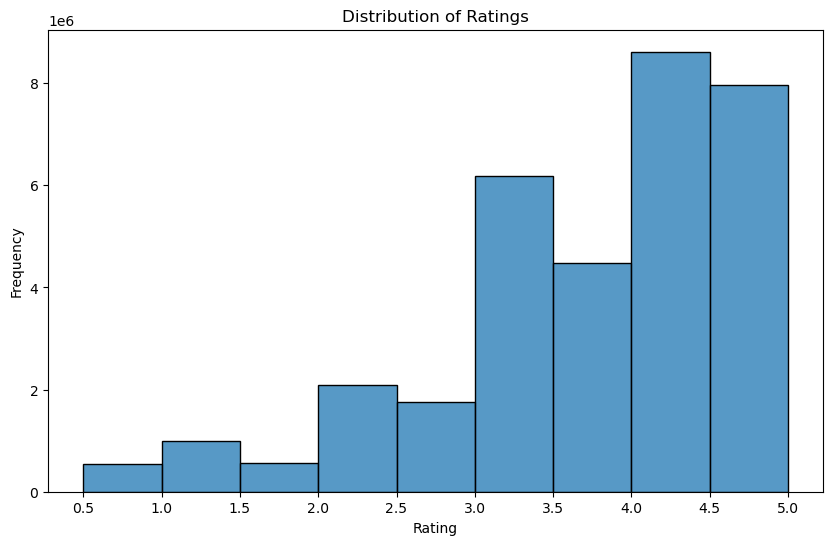

In [11]:
# Improved plot for the distribution of ratings with specific bins
plt.figure(figsize=(10, 6))
bins = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
sns.histplot(user_enriched_df['rating'], bins=bins, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(bins)  # Set x-ticks to match the bins
plt.show()



## Distribution of Ratings

The histogram above shows the distribution of ratings in the dataset. Here are some key observations:

1. **Rating Scale**:
   - The ratings range from 0.5 to 5, with increments of 0.5.
   - Each bar in the histogram represents the frequency of a specific rating value.

2. **Most Common Ratings**:
   - The most common ratings are 4.0 and 4.5, indicating that users tend to rate movies quite positively.
   - There is also a significant number of ratings at the maximum value of 5.0.

3. **Least Common Ratings**:
   - The least common ratings are at the lower end of the scale (0.5, 1.0, and 1.5), indicating fewer very low ratings.

4. **Distribution Shape**:
   - The distribution is right-skewed, with a higher concentration of ratings towards the upper end of the scale.
   - This skewness suggests that users are generally more inclined to rate movies higher.

5. **Implications for Modeling**:
   - The skewness in the ratings distribution may need to be considered when developing recommendation models, as most users tend to give higher ratings.
   - Models should account for this tendency to avoid bias towards recommending only highly-rated movies.

By understanding the distribution of ratings, I can better tailor my recommendation algorithms to reflect user behaviour and preferences.


### Tag Frequency

I will analyse the frequency of the most common tags to understand what tags are most frequently used by users.


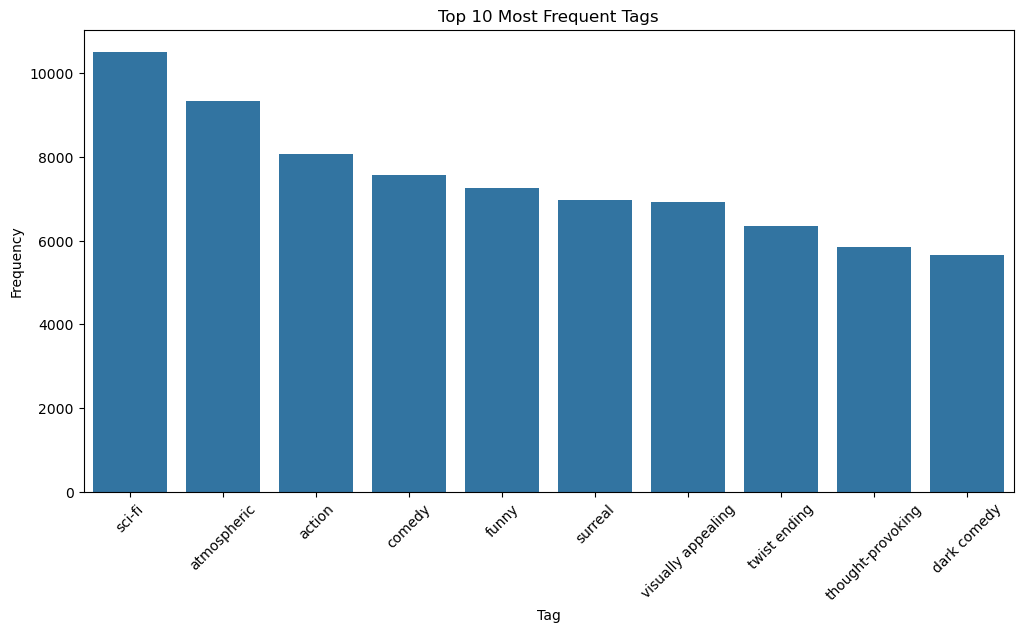

In [12]:
# Plot the frequency of the top 10 tags
top_10_tags = user_enriched_df['tag'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_tags.index, y=top_10_tags.values)
plt.title('Top 10 Most Frequent Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


## Top 10 Most Frequent Tags

The bar chart above shows the frequency of the top 10 most commonly used tags in the dataset. Here are some key observations:

1. **Most Frequent Tag**:
   - The most frequent tag is "sci-fi," with over 10,000 occurrences. This indicates a strong interest in sci-fi movies among users.

2. **Other Common Tags**:
   - Other popular tags include "atmospheric," "action," "comedy," and "funny," each appearing several thousand times. These tags suggest that users are also interested in the mood and genre of movies.

3. **Diverse Interests**:
   - Tags such as "surreal," "visually appealing," "twist ending," "thought-provoking," and "dark comedy" highlight the diversity in users' interests and the different aspects they consider important when tagging movies.
   
4. **Implications for Recommendations**:
   - Understanding the frequency of tags helps in building more nuanced recommendation systems that can suggest movies not only based on ratings but also on user-defined characteristics.
   - Tags provide additional context and can be used to enhance content-based filtering methods, making recommendations more relevant to users' specific tastes.

5. **User Engagement**:
   - The variety and frequency of tags also indicate active user engagement in tagging movies, which is a valuable source of data for personalising recommendations.

By leveraging the insights from these tags, we can better understand user preferences and improve the relevance of movie recommendations.


### User Activity

I will explore user activity by analysing the number of ratings and tags per user. This helps us understand user engagement with the platform.


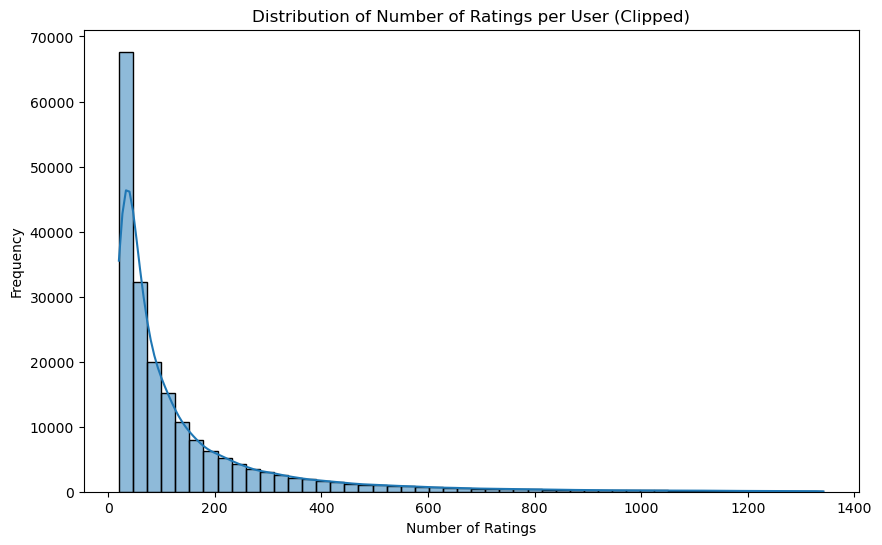

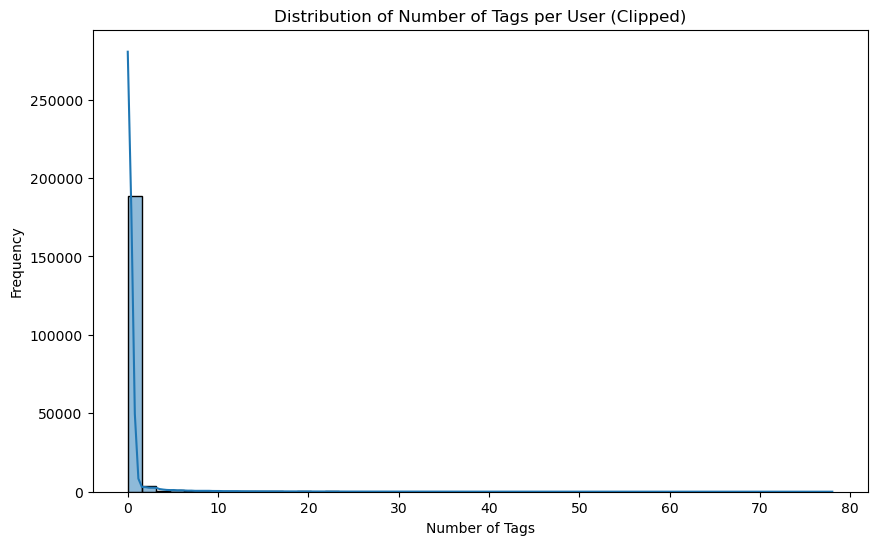

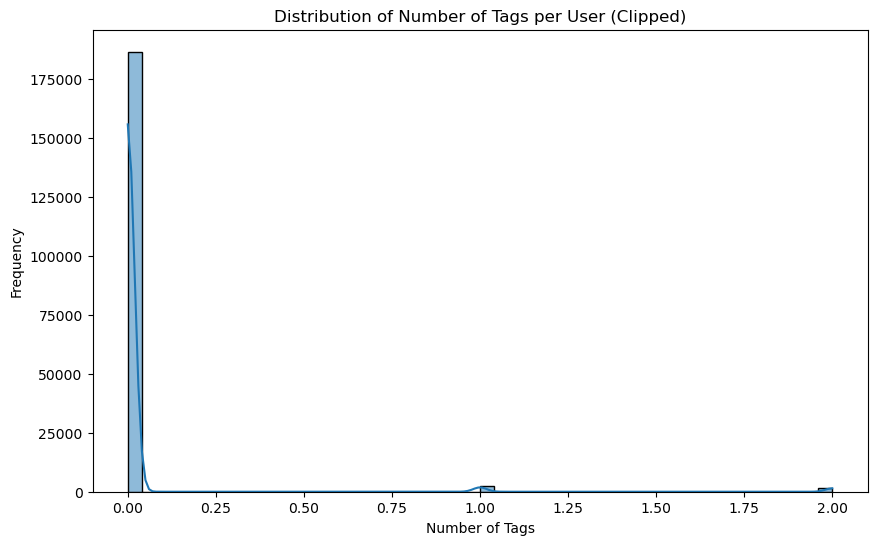

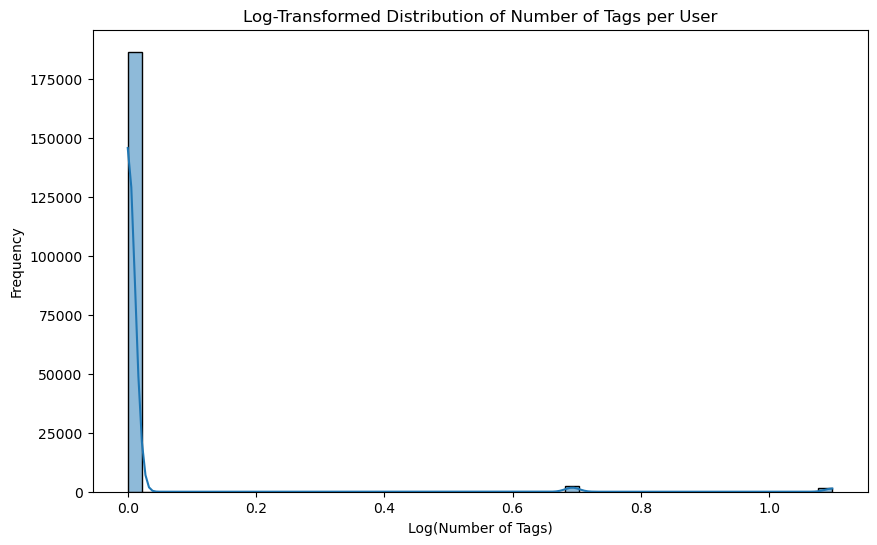

In [13]:
# Clip the extreme outliers for number of ratings per user
ratings_per_user = user_enriched_df.groupby('userId').size()
ratings_per_user_clipped = ratings_per_user[ratings_per_user < ratings_per_user.quantile(0.99)]

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user_clipped, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per User (Clipped)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Clip the extreme outliers for number of tags per user
tags_per_user = user_enriched_df['tag'].notnull().groupby(user_enriched_df['userId']).sum()
tags_per_user_clipped = tags_per_user[tags_per_user < tags_per_user.quantile(0.99)]

plt.figure(figsize=(10, 6))
sns.histplot(tags_per_user_clipped, bins=50, kde=True)
plt.title('Distribution of Number of Tags per User (Clipped)')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.show()

# Further clip the extreme outliers for number of tags per user
tags_per_user_clipped = tags_per_user[tags_per_user < tags_per_user.quantile(0.95)]

plt.figure(figsize=(10, 6))
sns.histplot(tags_per_user_clipped, bins=50, kde=True)
plt.title('Distribution of Number of Tags per User (Clipped)')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.show()

# Apply log transformation
tags_per_user_log = np.log1p(tags_per_user_clipped)

plt.figure(figsize=(10, 6))
sns.histplot(tags_per_user_log, bins=50, kde=True)
plt.title('Log-Transformed Distribution of Number of Tags per User')
plt.xlabel('Log(Number of Tags)')
plt.ylabel('Frequency')
plt.show()



## User Activity Analysis

### Distribution of Number of Ratings per User

The histogram above shows the distribution of the number of ratings per user after clipping the extreme outliers. Here are some key observations:

1. **Skewness**:
   - The distribution is highly right-skewed, indicating that most users have given a relatively small number of ratings.
   - The majority of users have rated fewer than 50 movies.

2. **Heavy-Tail**:
   - A small number of users are highly active, giving hundreds of ratings, but they are the minority.
   
3. **Implications**:
   - When building recommendation models, it's essential to account for the fact that most users provide only a few ratings. Models that rely on user data should be robust to sparse user interactions.
   - The heavy tail indicates that a small number of power users contribute a significant portion of the ratings, which might skew popularity-based recommendation systems.

### Distribution of Number of Tags per User

The histograms above show the distribution of the number of tags per user after clipping the extreme outliers and applying log transformation. Here are some key observations:

1. **Extremely Skewed Distribution**:
   - The vast majority of users have applied very few tags.
   - A large spike at 0 tags per user, followed by a steep drop-off, indicates that most users do not use tags frequently.

2. **Clipping and Transformation**:
   - Even after clipping the top 5% of users and applying log transformation, the distribution remains highly skewed.
   - Most users have fewer than 2 tags.

3. **Implications**:
   - The sparseness of the tagging data suggests that tag-based recommendation systems will need to handle a lot of missing data.
   - Models should be designed to work with sparse input data effectively.
   - Combining tags with other features, such as ratings and user interactions, may provide better recommendations.
   - Tags can be used as auxiliary information rather than primary features.

### Summary and Next Steps

The analysis of user activity reveals that both ratings and tags are highly skewed, with the majority of users having minimal interactions. This insight is crucial for the development of robust recommendation models. The next steps include:

1. **Feature Engineering**:
   - Create new features that capture user engagement and activity levels.
   - Consider the creation of a composite feature that combines ratings and tags.

2. **Advanced Models**:
   - Explore collaborative filtering techniques that can handle sparse data, such as Matrix Factorisation or Neural Collaborative Filtering.
   - Use hybrid models that combine content-based filtering (using tags) with collaborative filtering (using ratings).

3. **Data Visualisation**:
   - Use cumulative distribution functions (CDF) or percentiles to better understand the distribution of tags.
   - Visualise user activity over time to identify trends and patterns.

By following these steps, I can build a comprehensive recommendation system that leverages both ratings and tags, even in the presence of sparse data.


### Movie Popularity

I will explore movie popularity by analysing the number of ratings and tags per movie. This helps us understand which movies are most engaging to users.


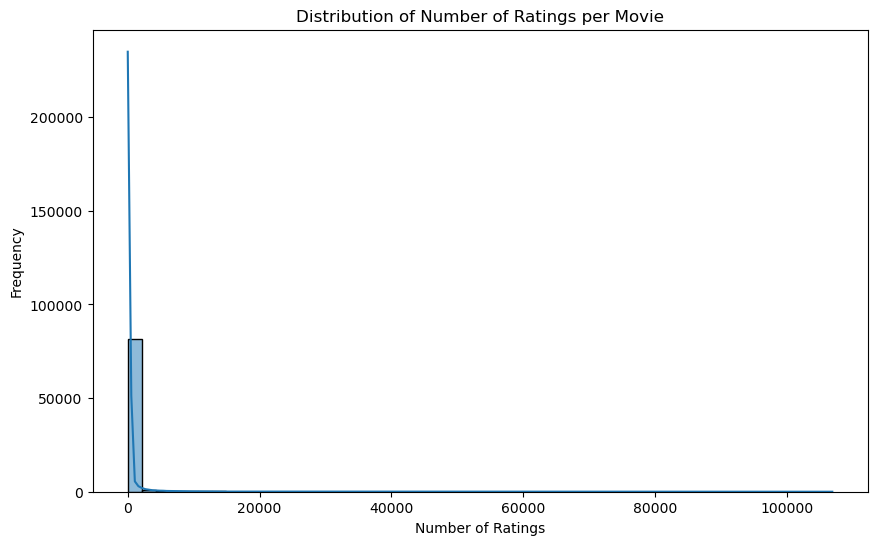

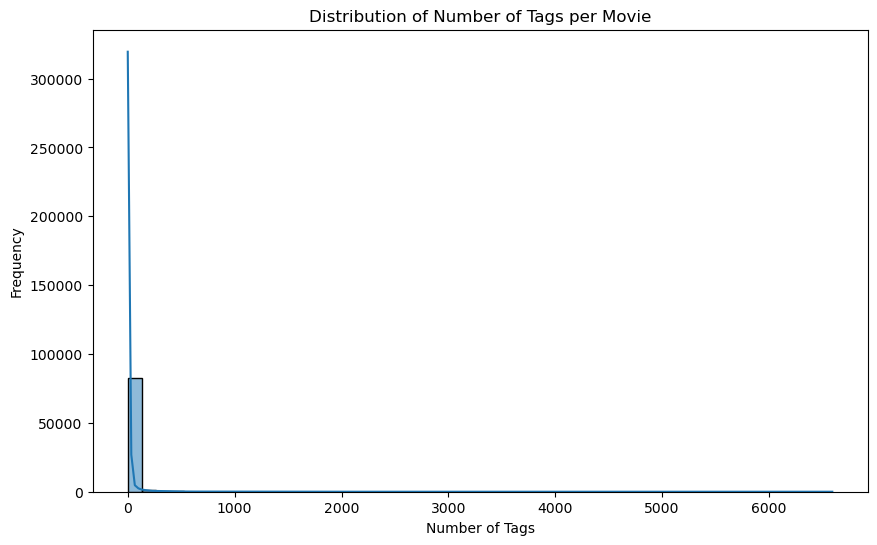

In [14]:
# Plot the number of ratings per movie
ratings_per_movie = user_enriched_df.groupby('movieId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Plot the number of tags per movie
tags_per_movie = user_enriched_df['tag'].notnull().groupby(user_enriched_df['movieId']).sum()
plt.figure(figsize=(10, 6))
sns.histplot(tags_per_movie, bins=50, kde=True)
plt.title('Distribution of Number of Tags per Movie')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.show()


### Temporal Patterns

I will analyse the temporal patterns of ratings and tags to understand how user activity changes over time.


/var/folders/__/gch_yp2d1ql3l011rt37_bbr0000gp/T/ipykernel_15287/3092530091.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ratings_over_time = user_enriched_df.set_index('timestamp_rat').resample('M').size()


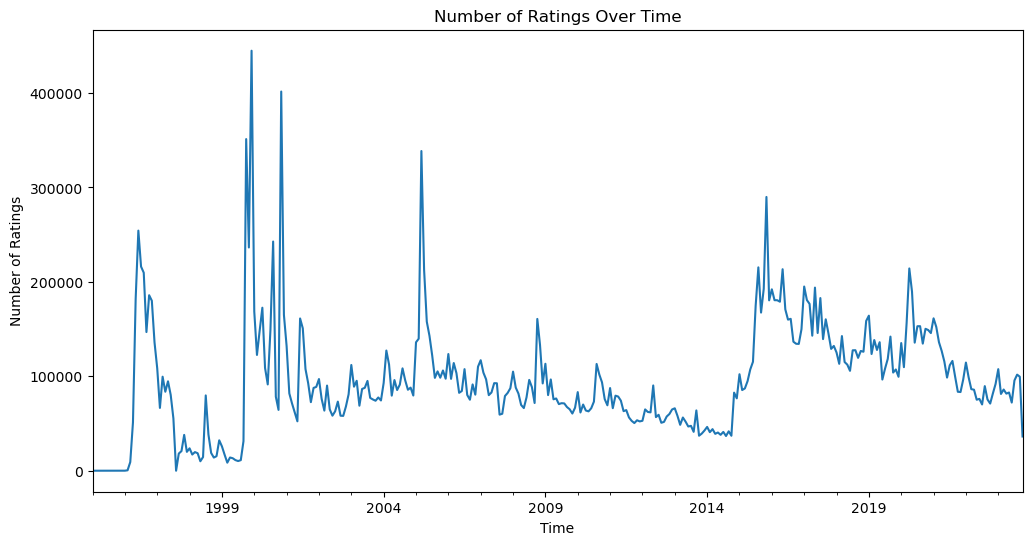

/var/folders/__/gch_yp2d1ql3l011rt37_bbr0000gp/T/ipykernel_15287/3092530091.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tags_over_time = user_enriched_df.set_index('timestamp_tag')['tag'].notnull().resample('M').sum()


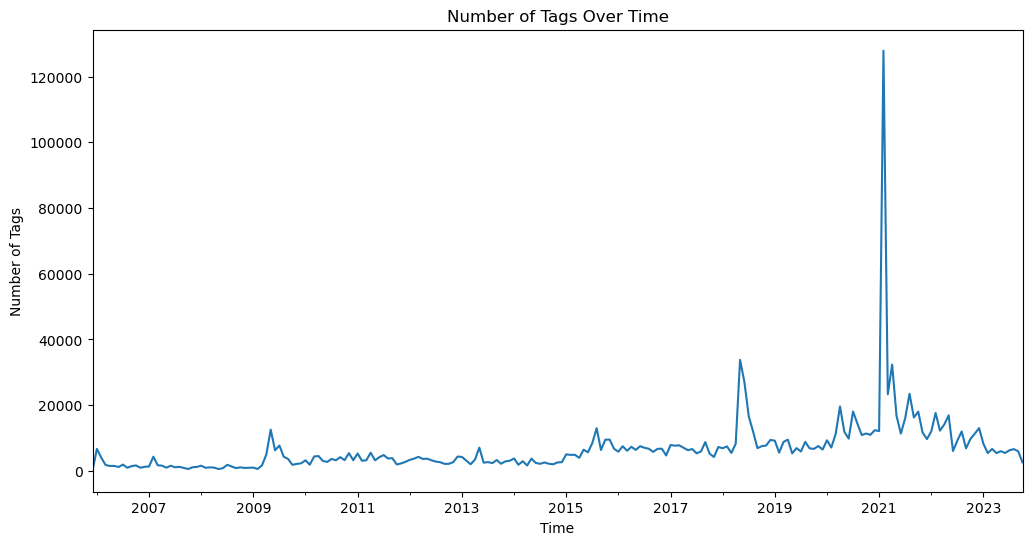

In [15]:
# Convert timestamp columns to datetime if not already
user_enriched_df['timestamp_rat'] = pd.to_datetime(user_enriched_df['timestamp_rat'])
user_enriched_df['timestamp_tag'] = pd.to_datetime(user_enriched_df['timestamp_tag'])

# Plot the number of ratings over time
ratings_over_time = user_enriched_df.set_index('timestamp_rat').resample('M').size()
plt.figure(figsize=(12, 6))
ratings_over_time.plot()
plt.title('Number of Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.show()

# Plot the number of tags over time
tags_over_time = user_enriched_df.set_index('timestamp_tag')['tag'].notnull().resample('M').sum()
plt.figure(figsize=(12, 6))
tags_over_time.plot()
plt.title('Number of Tags Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Tags')
plt.show()


## Ratings and Tags Over Time

### Ratings Over Time

The line graph above shows the number of ratings over time. Here are some key observations:

1. **Early Peaks and Volatility**:
   - There is a sharp increase in ratings during the late 1990s, followed by significant volatility.
   - Peaks and troughs during this period indicate fluctuating user activity, which could be attributed to specific events, changes in the platform, or new movie releases.

2. **Mid-2000s Decline**:
   - There is a noticeable decline in ratings around the mid-2000s, with sporadic peaks. This could be due to various factors, including changes in user engagement or platform policies.

3. **Steady Activity and Late 2010s Increase**:
   - From the late 2000s to the mid-2010s, the number of ratings shows more stability, with occasional peaks.
   - A significant increase in ratings is observed around 2016, which could indicate a rise in platform popularity, new features, or an increased user base.

4. **Recent Trends**:
   - There is a consistent level of user activity from 2016 onwards, with some fluctuations.
   - The recent trends show periodic increases in ratings, suggesting ongoing user engagement and platform activity.

#### Implications:

- The volatility in the number of ratings over time highlights the need for temporal dynamics to be considered in recommendation models.
- Understanding the factors contributing to peaks and troughs in user activity can help in designing better engagement strategies and improving recommendation accuracy.

### Tags Over Time

The line graph above shows the number of tags over time. Here are some key observations:

1. **Sparse Early Activity**:
   - The number of tags remains relatively low from 2007 to 2009, indicating minimal tagging activity during the early years.

2. **Gradual Increase and Volatility**:
   - There is a gradual increase in tagging activity starting around 2009, with some periodic peaks.
   - The number of tags fluctuates but shows an overall upward trend until 2021.

3. **Significant Peak in 2021**:
   - A substantial spike in the number of tags is observed in early 2021. This could be due to a specific event, promotion, or change in the platform that encouraged tagging.

4. **Post-2021 Decline**:
   - After the peak in 2021, there is a noticeable decline in tagging activity, with some fluctuations.
   - The recent trend shows reduced tagging activity, which might indicate changes in user behaviour or platform features.

#### Implications:

- The relatively low tagging activity compared to ratings suggests that tags might need to be used as supplementary data in recommendation models.
- The significant peak in 2021 indicates that external factors can heavily influence tagging behaviour. Identifying these factors can help in leveraging tags more effectively.

### Summary

The temporal analysis of ratings and tags provides valuable insights into user behaviour and platform activity over time. Both ratings and tags exhibit periods of volatility and significant peaks, highlighting the importance of considering temporal dynamics in recommendation systems. Understanding these trends can aid in designing better user engagement strategies and improving the overall effectiveness of recommendations.


### Feature Engineering

Given the skewed distribution of tags, I will create new features that combine user engagement levels across ratings and tags.


In [16]:
# Create a feature for the total number of interactions per user (ratings + tags)
user_engagement = user_enriched_df.groupby('userId').agg(
    total_ratings=('rating', 'count'),
    total_tags=('tag', 'count')
)

# Create a composite engagement score
user_engagement['engagement_score'] = user_engagement['total_ratings'] + user_engagement['total_tags']

# Normalize the engagement score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
user_engagement['engagement_score_norm'] = scaler.fit_transform(user_engagement[['engagement_score']])

# Display the first few rows of the user engagement DataFrame
print(user_engagement.head())


        total_ratings  total_tags  engagement_score  engagement_score_norm
userId                                                                    
1                 141           0               141               0.000234
2                  52           0                52               0.000062
3                 147           0               147               0.000245
4                  27           0                27               0.000014
5                  33           0                33               0.000025


### Advanced Models

To handle the sparse tagging data, we will explore collaborative filtering techniques and hybrid models.
1. Matrix Factorization
2. Neural Collaborative Filtering
3. Hybrid Models


## Matrix Factorization

I will use Matrix Factorization techniques to handle the sparse user-item interaction data and capture latent factors.


In [17]:
# from scipy.sparse import csr_matrix
# from sklearn.decomposition import TruncatedSVD

# # Aggregate duplicate ratings by taking the mean
# user_enriched_df_agg = user_enriched_df.groupby(['userId', 'movieId']).agg({'rating': 'mean'}).reset_index()

# # Now pivot the table to create the interaction matrix
# interaction_matrix = user_enriched_df_agg.pivot(index='userId', columns='movieId', values='rating').fillna(0)
# interaction_matrix_sparse = csr_matrix(interaction_matrix.values)

# # Apply Truncated SVD
# svd = TruncatedSVD(n_components=50, random_state=42)
# matrix_factorization = svd.fit_transform(interaction_matrix_sparse)

# # Display the shape of the factorized matrix
# print(matrix_factorization.shape)


# Step 1: Aggregate duplicate ratings by taking the mean
user_enriched_df_agg = user_enriched_df.groupby(['userId', 'movieId'])['rating'].mean().reset_index()

# Step 2: Convert the aggregated DataFrame into a sparse matrix directly
# Map the userId and movieId to categorical indices for efficient matrix operations
user_codes = user_enriched_df_agg['userId'].astype('category').cat.codes
movie_codes = user_enriched_df_agg['movieId'].astype('category').cat.codes
ratings = user_enriched_df_agg['rating'].values

# Create a sparse matrix with the user and movie codes as indices
interaction_matrix_sparse = csr_matrix((ratings, (user_codes, movie_codes)))

# Step 3: Apply Truncated SVD
svd = TruncatedSVD(n_components=50, random_state=42)
matrix_factorization = svd.fit_transform(interaction_matrix_sparse)

# Step 4: Display the shape of the factorized matrix
print(matrix_factorization.shape)



(200948, 50)


## Neural Collaborative Filtering

I will develop a neural network-based model to learn complex interaction patterns between users and movies.


In [19]:
# Define the neural collaborative filtering model
num_users = user_enriched_df['userId'].nunique()
num_movies = user_enriched_df['movieId'].nunique()

# User and movie input layers
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# User and movie embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=50)(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=50)(movie_input)

# Flatten the embeddings
user_flatten = Flatten()(user_embedding)
movie_flatten = Flatten()(movie_embedding)

# Concatenate the flattened embeddings
concat_layer = Concatenate()([user_flatten, movie_flatten])

# Fully connected layers
dense_layer = Dense(128, activation='relu')(concat_layer)
output_layer = Dense(1)(dense_layer)

# Create the model
model = Model(inputs=[user_input, movie_input], outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        10047400    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        4221600     ['input_2[0][0]']                
                                                                                              

## Hybrid Model

I will combine collaborative filtering with content-based filtering to leverage multiple data sources.


In [21]:
# Step 1: Aggregate duplicate ratings by taking the mean
user_enriched_df_agg = user_enriched_df.groupby(['userId', 'movieId'])['rating'].mean().reset_index()

# Step 2: Convert the aggregated DataFrame into a sparse matrix
# Map userId and movieId to categorical indices for efficient matrix operations
user_codes = user_enriched_df_agg['userId'].astype('category').cat.codes
movie_codes = user_enriched_df_agg['movieId'].astype('category').cat.codes
ratings = user_enriched_df_agg['rating'].values

# Create a sparse matrix
interaction_matrix_sparse = csr_matrix((ratings, (user_codes, movie_codes)))

# Step 3: Apply Truncated SVD for matrix factorization
svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(interaction_matrix_sparse)
movie_factors = svd.components_.T  # Transpose to match user factors

# Step 4: Define the prediction function
def predict_rating(user_id, movie_id):
    user_vector = user_factors[user_id]
    movie_vector = movie_factors[movie_id]
    prediction = user_vector.dot(movie_vector)
    return prediction

# Example prediction
user_id = 0  # Index-based user ID
movie_id = 50  # Index-based movie ID
print(f'Matrix Factorization Prediction for user {user_id} and movie {movie_id}: {predict_rating(user_id, movie_id)}')


Matrix Factorization Prediction for user 0 and movie 50: -0.00029520041870666344
